In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Importing Dataset

In [31]:
df = pd.read_csv('Dataset.csv')

#### 1. Dataset

i. This dataset is publicly available and is developed, maintained, and managed by **Health Canada**.

ii. It contains data dating back to 2016, when it was first reported, and is updated annually. The dataset can be accessed [here](https://health-infobase.canada.ca/substance-related-harms/opioids-stimulants/).

iii. Users can select between Opioids and Stimulants as the focus of analysis. For this project, both categories will be utilized.

iv. The dataset includes information on hospitalizations, emergency department visits, Emergency Medical Services (EMS) responses, and fatalities. Data is available by year or quarter and can be segmented by age group, gender, or a combination of both.

v. Three calculation methods are available:
* _Crude Rate_: Expressed per 100,000 people, commonly used for provincial-level data.
* _Percent_: Represents the proportion within a specific group and event.
* _Number_: The total count of cases within a given group and event.

#### 2. Data Wrangling

Before starting the analysis, we will make some adjustments to the data to improve readability, visualization and to make it easier to understand.

**1.** We will group smaller provinces within their geography. New Brunswick, Nova Scotia, Prince Edward Island and Newfoundland and Labrador will be grouped as _Atlantic Canada_ and Northwest Territories, Nunavut and Yukon will be grouped as _Canadian Territories_.

**2.** The column PRUID will be dropped as contains only an ID related to the column 'Type Event'

**3.** Some Data were supressed by the Provincial/Federal Governments and appear as "Suppr." on the column 'Value'. We will drop these rows as they have no valuable data.

**4.** We will split the datasets into Opioids and Stimulants, as each group of substance will be compared separately.

In [12]:
df['Region'].unique()

array(['Canada', 'British Columbia', 'Alberta', 'Saskatchewan',
       'Manitoba', 'Ontario', 'Quebec', 'New Brunswick', 'Nova Scotia',
       'Prince Edward Island', 'Newfoundland and Labrador', 'Yukon',
       'Northwest Territories', 'Nunavut', 'Territories',
       'Winnipeg, Manitoba', 'Northern and rural Manitoba',
       'Whitehorse, Yukon', 'Yellowknife, Northwest Territories'],
      dtype=object)

In [32]:
#Dropping PRUID
df = df.drop(['PRUID'],axis=1)

In [33]:
#Grouping Provinces by their Geography
df['Region'] = df['Region'].replace(['New Brunswick', 'Nova Scotia','Prince Edward Island', 'Newfoundland and Labrador'], 'Atlantic Canada')
df['Region'] = df['Region'].replace(['Yukon','Northwest Territories', 'Nunavut', 'Territories'], 'Canadian Territories')

In [40]:
#Dropping rows with Suppressed values
df = df.loc[df['Value'] != 'Suppr.']

In [56]:
#Adjusting the Data Type for 'Value' column
df['Value'] = df['Value'].astype('float')

C:\Users\jbertti\AppData\Local\Temp\ipykernel_37268\2751274160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'] = df['Value'].astype('float')


#### 3. Exploratory Data Analysis (EDA)

##### Guiding Question 1: What is the growth percentage of incidents by Province from 2016 to 2023?

In [113]:
gq1_o = df.loc[(df['Type_Event'] == 'Total apparent opioid toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Opioids')]
gq1_s = df.loc[(df['Type_Event'] == 'Total apparent stimulant toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Stimulants')]

In [114]:
gq1_o = pd.pivot_table(data=gq1_o,index='Region',columns='Year_Quarter',values='Value',aggfunc='sum').reset_index()
gq1_s = pd.pivot_table(data=gq1_s,index='Region',columns='Year_Quarter',values='Value',aggfunc='sum').reset_index()

To perform a better analysis and answer this question, lets calculate the **Compound Annual Growth Rate (CAGR)**. This tool is useful when we want to perform a study with a determined variable over time, specially when the value of the time-series data are independent in time.

The CAGR is determined by:

$$
CAGR = \left( \frac{V_f}{V_i} \right)^{\frac{1}{n}}-1
$$

Where:
- $( V_{f} )$ = Final Value (e.g., value in 2023)
- $( V_{i} )$ = Initial Value (e.g., value in 2016)
- $( n )$ = Number of years


In [115]:
#Calculating the Compound Annual Growth Rate
gq1_o['CAGR'] = ((gq1_o['2023']/gq1_o['2016'])**(1/8))-1
gq1_s['CAGR'] = ((gq1_s['2021']/gq1_s['2018'])**(1/4))-1

In [118]:
#Adjusting the Calculation of the CAGR due to inconsistencies on the data
gq1_s.loc[gq1_s['Region'] == 'Quebec', 'CAGR'] = ((gq1_s['2021']/gq1_s['2018'])**(1/4))-1
gq1_s.loc[gq1_s['Region'] == 'Manitoba', 'CAGR'] = ((gq1_s['2023']/gq1_s['2019'])**(1/5))-1
gq1_s.loc[gq1_s['Region'] == 'Canadian Territories', 'CAGR'] = ((gq1_s['2023']/gq1_s['2020'])**(1/4))-1

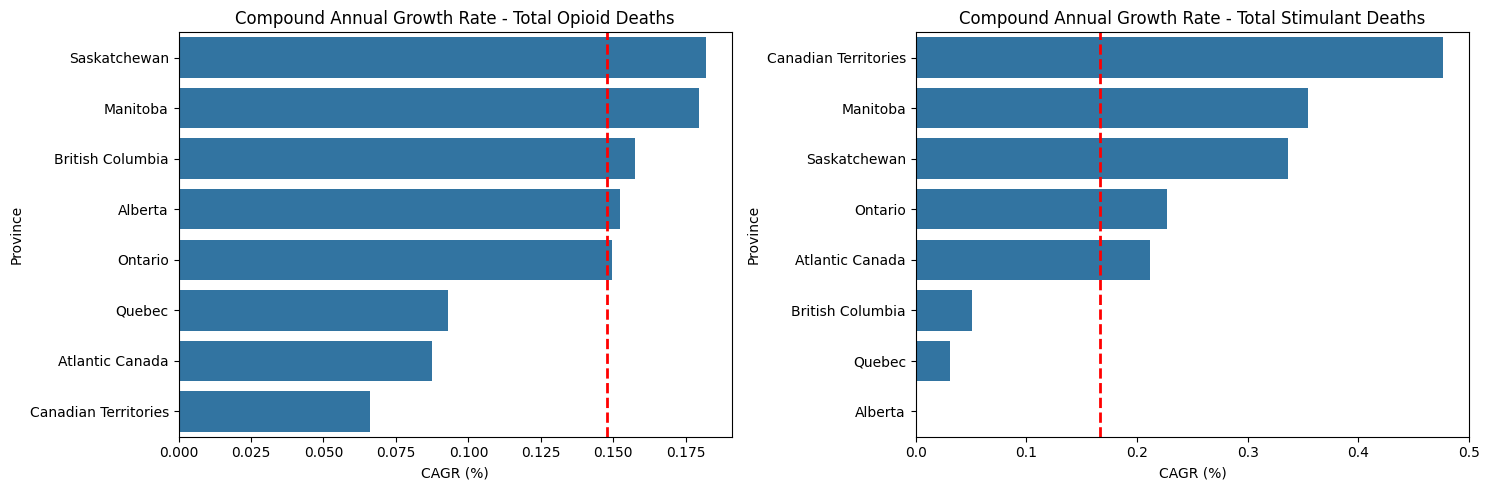

In [145]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(data=gq1_o.loc[gq1_o['Region'] != 'Canada'].sort_values(by='CAGR',ascending=False),x='CAGR',y='Region',ax=axes[0])
axes[0].set_title('Compound Annual Growth Rate - Total Opioid Deaths')
axes[0].set_xlabel('CAGR (%)')
axes[0].set_ylabel('Province')
canada_cagr = gq1_o.loc[gq1_o['Region'] == 'Canada', 'CAGR'].values[0]
axes[0].axvline(x=canada_cagr, color="red", linewidth=2, linestyle='--')

sns.barplot(data=gq1_s.loc[gq1_s['Region'] != 'Canada'].sort_values(by='CAGR',ascending=False),x='CAGR',y='Region',ax=axes[1])
axes[1].set_title('Compound Annual Growth Rate - Total Stimulant Deaths')
axes[1].set_xlabel('CAGR (%)')
axes[1].set_ylabel('Province')
canada_cagr_s = gq1_s.loc[gq1_o['Region'] == 'Canada', 'CAGR'].values[0]
axes[1].axvline(x=canada_cagr_s, color="red", linewidth=2, linestyle='--')
plt.tight_layout()

The charts above display the **Compound Annual Growth Rate (CAGR)** for opioid and stimulant deaths across Canadian provinces from 2016 to 2023. The **<span style="color: navy;">blue bars</span>** represent the growth rate for each province, and the **<span style="color: red;">red line</span>** shows the national rate for Canada.

##### **Opioids**:
The highest growth in opioid deaths occurred in Manitoba and Saskatchewan, with a CAGR of about 17.5%.

Three provinces with a large population share — Alberta (AB), British Columbia (BC), and Ontario (ON) — had growth rates of around 15%. Quebec, despite being the third most populous, saw growth similar to smaller regions like Atlantic Canada and the Territories - approximately 10%. Nationally, Canada’s CAGR for opioid deaths from 2016 to 2023 was 14.8%.

##### **Stimulants:**
Stimulant data posed challenges as Alberta didn’t report, Quebec stopped in 2021, and Manitoba only began reporting in 2019. Therefore, CAGR calculations were adjusted for these reporting gaps.

Similar to opioids, stimulant-related deaths were notably higher in Central Canada, where growth rates exceeded 30%. Nationally, Canada’s stimulant death growth was about half that rate. British Columbia and Quebec were exceptions, with growth rates under 5%. Canadian Territories figures while concerning, have to be taken with caution because the size of the sample and population, but a 45% Growth increase is always concerning.

This highlights regional differences in stimulant-related deaths, with Central Canada seeing the largest increases, while British Columbia and Quebec experienced more less aggressive trends.

##### Guiding Question 2: Is there a specific group (Age, Sex) in which the growth was more prevalent?